# Preparation

In [11]:
# This file is based on: 2_regression_presence_of_accident
# Remove features which were found correlated with others
# Remove the categorical features which has only two categories
# Remove features identified by VIF

In [12]:
import torch
torch.cuda.empty_cache() 

In [13]:
import os 
os.environ['MPLCONFIGDIR'] = os.getcwd() + "/configs/"
import cv2
import urllib.request
from PIL import Image

In [14]:
from mtp_function_yl import *

In [15]:
# pip install scipy==1.14.0
import scipy

In [16]:
# pip install statsmodels==0.14.4
import statsmodels

In [43]:
import pandas as pd
import pyproj

import matplotlib
from matplotlib import pyplot as plt
import numpy as np

from pathlib import Path
from scipy import stats
from scipy.stats import ks_2samp
from tabulate import tabulate
import statsmodels.api as sm
import statsmodels.tools as tools
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
import seaborn as sn

# For regression
from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import PredictionErrorDisplay

import mlxtend
# For stepwise feature selection
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# VIF for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [19]:
# For documentation and version control
# pip install watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [20]:
%watermark  -u -d -v -m --iversions

Last updated: 2024-10-28

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-119-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 48
Architecture: 64bit

sklearn    : 1.3.0
pandas     : 2.0.3
shapely    : 2.0.2
matplotlib : 3.7.2
PIL        : 10.0.0
seaborn    : 0.12.2
statsmodels: 0.14.4
cv2        : 4.8.1
mlxtend    : 0.23.1
scipy      : 1.14.0
torch      : 2.0.1
numpy      : 1.26.4
pyproj     : 3.6.1



# Data loading

## For science cluster environment

In [21]:
aa = pd.read_csv('/home/yelhe/script/mt/dataraw/dfaa.csv')

In [22]:
acv = pd.read_csv('/home/yelhe/script/mt/model/allvariable_accident.csv')
# rpv = pd.read_csv('/home/yelhe/script/mt/model/allvariable_rp.csv')

In [23]:
# Create presence of person injury
acv0 = acv.copy(deep = True)
acv0 = acv0.assign(inp = 1)
acv0.loc[(acv0['svp'] == 0) & (acv0['lvp'] == 0), 'inp'] = 0

In [24]:
# acv0.to_csv('/home/yelhe/script/mt/model/dfacrsv.csv', index = False)

In [25]:
dfacrsv = acv0.copy(deep = True)

In [80]:
dfacrsv.groupby('inp').size()

inp
0     40
1    255
dtype: int64

In [275]:
# i = i+1
# print(i)
# dfacrsv['inp'].equals(dfacrsv[cn[i]])

## Pre Processing

In [198]:
# Remove r_width_7, speedlimit_6, z_qnr_33, z_knr_12, trafficarea_3,
# Remove curbtype_1, dcurb, curbtype_2, r_surface_2
# (variance = 0) Remove 'r_surface_1', 'z_qnr_30','z_qnr_31'
# (low variance 0.003390) remove 'speedlimit_3', 'speedlimit_5', 'z_qnr_23', 'z_qnr_32',
# (low variance 0.006757) remove 'z_qnr_27', 'z_qnr_29',
# (low variance 0.010100) remove 'z_qnr_26', 'z_qnr_4', 'z_qnr_9'
cn = ['cp', 'cmean', 'cmin', 'cmax',  'ie', 'iemin', 'iemax', 'mew', 'mewmin',
      'mewmax', 'meg', 'megmin', 'megmax','dbusl', 'dtraml', 
      'dtrainl', 'dplight', 'dstation', 'dparkcar', 'dparktw', 'dpedcro', 'dstopsign', 
      'dtrafficarea', 'droad', 'dvfpath', 'gvm_dwv', 'gvm_msp', 'gvm_asp', 
      'r_width_value','speedlimit_value', 'bicyclecount', 'carcount',
      'z_qnr_1', 'z_qnr_2', 'z_qnr_3', 'z_qnr_5', 'z_qnr_6', 
      'z_qnr_7', 'z_qnr_8',  'z_qnr_10', 'z_qnr_11', 'z_qnr_12',
      'z_qnr_13', 'z_qnr_14', 'z_qnr_15', 'z_qnr_16', 'z_qnr_17', 'z_qnr_18',
      'z_qnr_19', 'z_qnr_20', 'z_qnr_21', 'z_qnr_22', 'z_qnr_24',
       'z_qnr_25',  'z_qnr_28', 
      'z_knr_1', 'z_knr_2', 'z_knr_3',
       'z_knr_4', 'z_knr_5', 'z_knr_6', 'z_knr_7', 'z_knr_8', 'z_knr_9',
       'z_knr_10', 'z_knr_11', 'trafficarea_1', 'trafficarea_2',
      'r_width_1', 'r_width_2', 'r_width_3', 'r_width_4',
       'r_width_5', 'r_width_6',
       'speedlimit_1', 'speedlimit_2','speedlimit_4' ]

In [160]:
# i = i+1
# dfa = dfacrsv[cn]
# dfa.groupby(cn[i]).size()
# # dfa.groupby('z_qnr_2').size()


In [99]:
dfv = dfacrsv[cn]
dfv.var().sort_values()

z_qnr_28         0.013421
z_qnr_13         0.013421
z_qnr_2          0.013421
z_qnr_3          0.016719
r_width_2        0.019993
                   ...   
r_width_value    1.032744
dbusl            1.033963
bicyclecount     1.034020
dstopsign        1.045260
dparktw          1.052253
Length: 77, dtype: float64

In [29]:
# Correlation
dfv = dfacrsv[cn]
corr_matrix = dfv.corr()
upper_corrmat = corr_matrix.where(
                np.triu(np.ones(corr_matrix.shape),k = 1).astype(bool))
unique_corrpair = upper_corrmat.unstack().dropna()
sorted_uni_cp = unique_corrpair.sort_values()

In [30]:
sorted_uni_cp

speedlimit_2   speedlimit_value   -0.842319
speedlimit_4   speedlimit_1       -0.672881
trafficarea_2  trafficarea_1      -0.669003
r_width_1      r_width_value      -0.566343
trafficarea_1  z_knr_9            -0.543506
                                     ...   
cmax           cp                  0.969154
               cmean               0.976786
gvm_msp        gvm_dwv             0.983475
gvm_asp        gvm_msp             0.985719
               gvm_dwv             0.987063
Length: 2926, dtype: float64

In [31]:
dfcorr = sorted_uni_cp.to_frame()

In [32]:
dfcorr.loc[(dfcorr[0] >= 0.8) | (dfcorr[0] <= -0.8)]

,,0
speedlimit_2,speedlimit_value,-0.842319
z_knr_3,z_qnr_7,0.827680
speedlimit_4,speedlimit_value,0.837207
r_width_5,r_width_value,0.848569
mewmax,mew,0.861316
megmin,meg,0.861510
z_knr_1,z_qnr_1,0.881660
mewmin,mew,0.904819
z_knr_7,z_qnr_12,0.906208
iemax,ie,0.923209


In [33]:
# For high correlation
# Remove 'cp', 'r_width_5', 'z_qnr_16', 'z_qnr_12', 'z_qnr_1', 'speedlimit_4', 'z_qnr_7'
# Remove 'cmax','gvm_asp', 'gvm_msp', 'iemin', 'iemax','mewmin','megmin','mewmax',
# Remove 'speedlimit_2'
cnu = ['cmean', 'cmin', 'ie',  'mew', 'meg',  'megmax',
       'dbusl', 'dtraml', 'dtrainl', 'dplight', 'dstation', 'dparkcar', 'dparktw', 
       'dpedcro', 'dstopsign', 'dtrafficarea', 'droad', 'dvfpath', 'gvm_dwv',
       'r_width_value','speedlimit_value', 'bicyclecount', 'carcount',
       'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_5', 'z_qnr_6', 
       'z_qnr_8', 'z_qnr_9', 'z_qnr_10', 'z_qnr_11',
        'z_qnr_13', 'z_qnr_14', 'z_qnr_15', 'z_qnr_17', 'z_qnr_18',
       'z_qnr_19', 'z_qnr_20', 'z_qnr_21', 'z_qnr_22', 'z_qnr_24',
       'z_qnr_25', 'z_qnr_28', 
       'z_knr_1', 'z_knr_2', 'z_knr_3',
        'z_knr_5', 'z_knr_6', 'z_knr_7', 'z_knr_8', 
       'z_knr_10', 'z_knr_11', 'trafficarea_1', 'trafficarea_2',
       'r_width_1', 'r_width_2', 'r_width_3', 'r_width_4', 
       'r_width_6', 'speedlimit_1']
print(len(cnu))

61


In [34]:
# Correlation
dfv = dfacrsv[cnu]
corr_matrix = dfv.corr()
upper_corrmat = corr_matrix.where(
                np.triu(np.ones(corr_matrix.shape),k = 1).astype(bool))
unique_corrpair = upper_corrmat.unstack().dropna()
sorted_uni_cp = unique_corrpair.sort_values()
sorted_uni_cp

trafficarea_2  trafficarea_1   -0.669003
r_width_1      r_width_value   -0.566343
speedlimit_1   dtrafficarea    -0.525379
trafficarea_1  z_qnr_22        -0.386975
r_width_6      r_width_value   -0.364367
                                  ...   
z_knr_10       z_qnr_24         0.673575
z_knr_11       z_qnr_28         0.702230
megmax         meg              0.761828
z_knr_2        z_qnr_10         0.769217
z_knr_6        z_qnr_8          0.786991
Length: 1830, dtype: float64

In [35]:
# calculating VIF for each feature
# Remove 'z_knr_5','z_knr_6', 'z_knr_2', 'z_knr_10','r_width_1','z_qnr_11','trafficarea_2',

cnu1 = ['cmean', 'cmin', 'ie',  'mew', 'meg',  'megmax',
        'dbusl', 'dtraml', 'dtrainl', 'dplight', 'dstation', 'dparkcar', 'dparktw', 
        'dpedcro', 'dstopsign', 'dtrafficarea', 'droad', 'dvfpath', 'gvm_dwv',
        'r_width_value','speedlimit_value', 'bicyclecount', 'carcount',
        'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_5', 'z_qnr_6', 
        'z_qnr_8', 'z_qnr_9', 'z_qnr_10', 
        'z_qnr_13', 'z_qnr_14', 'z_qnr_15', 'z_qnr_17', 'z_qnr_18',
        'z_qnr_19', 'z_qnr_20', 'z_qnr_21', 'z_qnr_22', 'z_qnr_24',
        'z_qnr_25', 'z_qnr_28', 'z_knr_1',  'z_knr_3',
        'z_knr_7', 'z_knr_8', 'z_knr_11', 'trafficarea_1', 
        'r_width_2', 'r_width_3', 'r_width_4', 
        'r_width_6', 'speedlimit_1']

X = dfacrsv[cnu1]
X1 = tools.add_constant(X)
dfcnu_vif = pd.DataFrame()
dfcnu_vif["feature"] = X1.columns
dfcnu_vif["VIF"] = [variance_inflation_factor(X1.values, i)
                          for i in range(len(X1.columns))]

print(len(cnu1), dfcnu_vif.sort_values(by = ['VIF']))
# vifh = dfcnu_vif.loc[dfcnu_vif['VIF'] >= 5]
# vifhl = vifh['feature'].tolist()
# print(vifhl)
# dfcnu_vif.to_csv('/home/yelhe/script/mtp/tables/as_VIF_1.csv', index = False)

54              feature        VIF
2               cmin   1.226707
22      bicyclecount   1.314501
10           dplight   1.317557
3                 ie   1.322117
50         r_width_2   1.345849
30           z_qnr_9   1.354896
32          z_qnr_13   1.356177
26           z_qnr_4   1.363216
33          z_qnr_14   1.379374
41          z_qnr_24   1.397349
47           z_knr_8   1.409538
34          z_qnr_15   1.410787
42          z_qnr_25   1.440508
24           z_qnr_2   1.444295
36          z_qnr_18   1.454168
14           dpedcro   1.458521
31          z_qnr_10   1.460273
25           z_qnr_3   1.462091
51         r_width_3   1.462477
23          carcount   1.554964
53         r_width_6   1.564762
1              cmean   1.582491
35          z_qnr_17   1.618938
11          dstation   1.621943
52         r_width_4   1.667840
38          z_qnr_20   1.675450
28           z_qnr_6   1.785674
9            dtrainl   1.808725
13           dparktw   1.844959
39          z_qnr_21   1.935311
19   

In [36]:
print(len(cnu1))

54


In [37]:
x = dfacrsv[cnu1] 
# For severity of accident
# Binary dependent variables
y1 = dfacrsv['inp'] # presence of person injury
y2 = dfacrsv['pdp'] # presence of property damage
y3 = dfacrsv['lvp'] # presence of lightly injured
y4 = dfacrsv['svp'] # presence of severely injured
# Numeric dependent variables
y5 = dfacrsv['LV']
y6 = dfacrsv['SV']
y7 = dfacrsv['pd']

In [68]:
# y.shape
x.shape
# 295 points with 60 features in total

(295, 54)

In [40]:
def check_cv_dist (df, dev):
    df1 = df.loc[df[dev] == 1]
    df0 = df.loc[df[dev] == 0]
    cvl = ['cp', 'cmean', 'cmin', 'cmax']
    print(cvl[0], ks_2samp(df1[cvl[0]], df0[cvl[0]]))
    print(cvl[1], ks_2samp(df1[cvl[1]], df0[cvl[1]]))
    print(cvl[2], ks_2samp(df1[cvl[2]], df0[cvl[2]]))
    print(cvl[3], ks_2samp(df1[cvl[3]], df0[cvl[3]]))

In [44]:
check_cv_dist(dfacrsv, 'inp')

cp KstestResult(statistic=0.00980392156862745, pvalue=1.0, statistic_location=0, statistic_sign=-1)
cmean KstestResult(statistic=0.027450980392156862, pvalue=0.9999999999999981, statistic_location=1.7519618970807305, statistic_sign=-1)
cmin KstestResult(statistic=0.01568627450980392, pvalue=1.0, statistic_location=-0.1172420763521098, statistic_sign=-1)
cmax KstestResult(statistic=0.03137254901960784, pvalue=0.999999999995699, statistic_location=1.4358700609298287, statistic_sign=-1)


In [45]:
check_cv_dist(dfacrsv, 'pdp')

cp KstestResult(statistic=0.0574606968833318, pvalue=0.9504836658059234, statistic_location=0, statistic_sign=-1)
cmean KstestResult(statistic=0.0574606968833318, pvalue=0.9504836658059234, statistic_location=-0.9559721771356244, statistic_sign=-1)
cmin KstestResult(statistic=0.013836535809506298, pvalue=1.0, statistic_location=-0.1172420763521098, statistic_sign=1)
cmax KstestResult(statistic=0.0574606968833318, pvalue=0.9504836658059234, statistic_location=-0.9857218406672054, statistic_sign=-1)


In [46]:
check_cv_dist(dfacrsv, 'lvp')

cp KstestResult(statistic=0.003409865878608775, pvalue=1.0, statistic_location=0, statistic_sign=-1)
cmean KstestResult(statistic=0.0330188679245283, pvalue=0.9999989166149185, statistic_location=1.7519618970807305, statistic_sign=-1)
cmin KstestResult(statistic=0.018867924528301886, pvalue=1.0, statistic_location=-0.1172420763521098, statistic_sign=-1)
cmax KstestResult(statistic=0.026653784951125255, pvalue=0.999999999428004, statistic_location=0.7630739452214893, statistic_sign=1)


In [47]:
check_cv_dist(dfacrsv, 'svp')

cp KstestResult(statistic=0.022399203583872575, pvalue=1.0, statistic_location=0, statistic_sign=1)
cmean KstestResult(statistic=0.028455284552845527, pvalue=0.9999999999973915, statistic_location=1.7519618970807305, statistic_sign=1)
cmin KstestResult(statistic=0.016260162601626018, pvalue=1.0, statistic_location=-0.1172420763521098, statistic_sign=1)
cmax KstestResult(statistic=0.022399203583872575, pvalue=1.0, statistic_location=-0.9857218406672054, statistic_sign=1)


# Orginal regression model without feature selection

In [48]:
# # Only with curb-related variables
# xcp = dfacrsv[['cmean','cp', 'cmin', 'cmax']]
# x_const = tools.add_constant(xcp)
# # m00_c = sm.OLS(y, x_const)
# # r00_c = m00_c.fit()
# # r00_c.summary()

# m00_log_c = sm.Logit(y3,x_const, max_iter = 400)
# r00_log_c = m00_log_c.fit_regularized()
# r00_log_c.summary()

## OLS linear regression

### Without data splitting

In [361]:
y = y6
# Binary dependent variables
# y1 = dfacrsv['inp'] # presence of person injury
# y2 = dfacrsv['pdp'] # presence of property damage
# y3 = dfacrsv['lvp'] # presence of lightly injured
# y4 = dfacrsv['svp'] # presence of severely injured
# # Numeric dependent variables
# y5 = dfacrsv['LV']
# y6 = dfacrsv['SV']
# y7 = dfacrsv['pd']

# y1 'inp' always has errors of singular matrix in logit regression
# y2 'pdp' sometimes has errors of singular matrix in logit regression

In [362]:
# OLS
# With constant
x_const = tools.add_constant(x)
m00 = sm.OLS(y, x_const)
r00 = m00.fit()
r00.summary()

# m00 = sm.OLS(y, x)
# r00 = m00.fit()
# r00.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SV   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.192
Date:                Mon, 28 Oct 2024   Prob (F-statistic):              0.189
Time:                        19:14:53   Log-Likelihood:                -91.967
No. Observations:                 295   AIC:                             293.9
Df Residuals:                     240   BIC:                             496.7
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1540      0.088      1.746      0.082      -0.020       0.328
cmean               -0.0077      0.027     -0.288      0.774      -0.061       0.045
cmin                -0.0263      0.024     -1.113      0.267      -0.073       0.020
ie                   0.0160      0.025      0.650      0.516      -0.032       0.064
mew                 -0.0441      0.030     -1.455      0.147      -0.104       0.016
meg                  0.0115      0.039      0.299      0.765      -0.064       0.087
megmax               0.0289      0.035      0.817      0.414      -0.041       0.099
dbusl               -0.0282      0.030     -0.945      0.346      -0.087       0.031
dtraml              -0.0178      0.031     -0.575      0.566      -0.079       0.043
dtrainl             -0.0260      0.029     -0.913      0.362      -0.082       0.030
dplight             -0.0319      0.025     -1.259      0.209      -0.082       0.018
dstation             0.0521      0.027      1.912      0.057      -0.002       0.106
dparkcar            -0.0080      0.030     -0.266      0.791      -0.067       0.051
dparktw              0.0076      0.028      0.267      0.789      -0.048       0.063
dpedcro              0.0150      0.026      0.582      0.561      -0.036       0.066
dstopsign            0.0331      0.033      1.012      0.313      -0.031       0.097
dtrafficarea         0.0131      0.033      0.395      0.693      -0.052       0.079
droad                0.0763      0.036      2.096      0.037       0.005       0.148
dvfpath             -0.0136      0.034     -0.403      0.687      -0.080       0.053
gvm_dwv              0.0613      0.030      2.065      0.040       0.003       0.120
r_width_value       -0.0053      0.031     -0.173      0.863      -0.066       0.055
speedlimit_value    -0.0054      0.031     -0.177      0.860      -0.066       0.055
bicyclecount        -0.0428      0.024     -1.778      0.077      -0.090       0.005
carcount            -0.0245      0.027     -0.916      0.361      -0.077       0.028
z_qnr_2              0.7808      0.222      3.522      0.001       0.344       1.217
z_qnr_3             -0.0364      0.200     -0.182      0.855      -0.430       0.357
z_qnr_4             -0.1369      0.248     -0.551      0.582      -0.626       0.352
z_qnr_5             -0.1066      0.121     -0.881      0.379      -0.345       0.132
z_qnr_6              0.3284      0.187      1.753      0.081      -0.041       0.697
z_qnr_8             -0.1183      0.144     -0.823      0.412      -0.401       0.165
z_qnr_9             -0.0983      0.247     -0.397      0.691      -0.586       0.389
z_qnr_10             0.1453      0.183      0.796      0.427      -0.214       0.505
z_qnr_13             0.0096      0.215      0.045      0.964      -0.414       0.433
z_qnr_14             0.

In [363]:
print(r00.rsquared_adj)

0.03404179041287758


In [364]:
def printsig(r):
    df = r.pvalues
    dfo = df[df<0.05]
    dfo = dfo.to_frame()
    dfo.loc[dfo[0] >= 0.01, 'sig'] = '*'
    dfo.loc[(dfo[0] < 0.01) & (dfo[0] >= 0.001) , 'sig'] = '**'
    dfo.loc[dfo[0] < 0.001, 'sig'] = '***'
    dfo = dfo.rename_axis('feature').reset_index()
    return dfo
    print(dfo)
    print(len(dfo))

In [365]:
printsig(r00)

,feature,0,sig
0,droad,0.037174,*
1,gvm_dwv,0.039970,*
2,z_qnr_2,0.000512,***
3,r_width_4,0.036497,*


0.8542372881355932

Test accuracy : 
 0.8542372881355932

Confusion Matrix : 
 [[244   2]
 [ 41   8]]


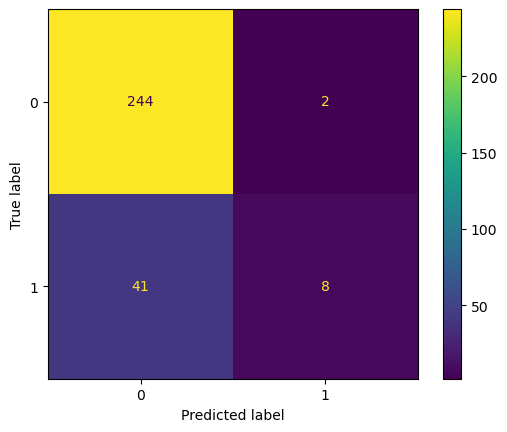

In [366]:
pred00 = r00.predict(x_const)
pred00 = list(map(round,pred00))
print(accuracy_score(y, pred00))
print('\nTest accuracy : \n', accuracy_score(y, pred00))
cm00 = confusion_matrix(y, pred00) 
print ('\nConfusion Matrix : \n', cm00)
cm00_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm00)
cm00_display.plot()

In [367]:
acc_ols = metrics.accuracy_score(y, pred00)
print('accuracy', acc_ols)

pre_ols = metrics.precision_score(y, pred00, average = None)
print('precision', pre_ols)

senrec_ols = metrics.recall_score(y, pred00, average = None)
print('sensitivity recall', senrec_ols)

f1_ols = metrics.f1_score(y, pred00, average = None)
print('f1 score', f1_ols)

pre_ols_m = np.mean(pre_ols)
senrec_ols_m = np.mean(senrec_ols)
f1_ols_m = np.mean(f1_ols)
print('mean precision', pre_ols_m)
print('mean recall', senrec_ols_m)
print('mean f1 score', f1_ols_m)

accuracy 0.8542372881355932
precision [0.85614035 0.8       ]
sensitivity recall [0.99186992 0.16326531]
f1 score [0.91902072 0.27118644]
mean precision 0.8280701754385965
mean recall 0.577567612410818
mean f1 score 0.5951035781544256


### With data splitting

In [368]:
# OLS
X_train, X_test, y_train, y_test = train_test_split(
        x_const, y,
        test_size=0.3,
        random_state=2)

m00_split = sm.OLS(y_train, X_train)
r00_split = m00_split.fit()
r00_split.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SV   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1.334
Date:                Mon, 28 Oct 2024   Prob (F-statistic):             0.0894
Time:                        19:15:06   Log-Likelihood:                -54.890
No. Observations:                 206   AIC:                             219.8
Df Residuals:                     151   BIC:                             402.8
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1407      0.126      1.121      0.264      -0.107       0.389
cmean                0.0051      0.034      0.151      0.880      -0.062       0.072
cmin                -0.0462      0.025     -1.831      0.069      -0.096       0.004
ie                   0.0036      0.032      0.114      0.909      -0.059       0.066
mew                 -0.0533      0.038     -1.394      0.165      -0.129       0.022
meg                  0.0379      0.049      0.769      0.443      -0.060       0.135
megmax               0.0246      0.042      0.584      0.560      -0.059       0.108
dbusl               -0.0909      0.040     -2.278      0.024      -0.170      -0.012
dtraml              -0.0268      0.039     -0.695      0.488      -0.103       0.049
dtrainl             -0.0254      0.038     -0.677      0.500      -0.100       0.049
dplight             -0.0303      0.034     -0.898      0.371      -0.097       0.036
dstation             0.0878      0.034      2.554      0.012       0.020       0.156
dparkcar            -0.0313      0.037     -0.846      0.399      -0.104       0.042
dparktw              0.0005      0.035      0.013      0.990      -0.069       0.070
dpedcro              0.0334      0.032      1.045      0.298      -0.030       0.096
dstopsign            0.0010      0.049      0.021      0.983      -0.096       0.098
dtrafficarea        -0.0101      0.047     -0.215      0.830      -0.103       0.083
droad                0.0984      0.043      2.265      0.025       0.013       0.184
dvfpath              0.0011      0.044      0.024      0.981      -0.086       0.088
gvm_dwv              0.0820      0.039      2.123      0.035       0.006       0.158
r_width_value       -0.0432      0.038     -1.127      0.262      -0.119       0.033
speedlimit_value    -0.0085      0.038     -0.221      0.826      -0.084       0.067
bicyclecount        -0.0699      0.033     -2.128      0.035      -0.135      -0.005
carcount            -0.0267      0.035     -0.754      0.452      -0.097       0.043
z_qnr_2              1.0892      0.523      2.084      0.039       0.056       2.122
z_qnr_3             -0.1125      0.278     -0.405      0.686      -0.661       0.436
z_qnr_4              0.1536      0.323      0.475      0.635      -0.485       0.793
z_qnr_5             -0.2029      0.146     -1.391      0.166      -0.491       0.085
z_qnr_6              0.2151      0.218      0.988      0.325      -0.215       0.645
z_qnr_8              0.0059      0.185      0.032      0.975      -0.359       0.371
z_qnr_9              0.1231      0.268      0.459      0.647      -0.407       0.653
z_qnr_10             0.1692      0.242      0.700      0.485      -0.308       0.647
z_qnr_13             0.0476      0.272      0.175      0.861      -0.490       0.585
z_qnr_14             0.

In [369]:
print(r00_split.rsquared_adj)
printsig(r00_split)

0.08084260598050419


,feature,0,sig
0,dbusl,0.024147,*
1,dstation,0.011633,*
2,droad,0.024952,*
3,gvm_dwv,0.035350,*
4,bicyclecount,0.034981,*
5,z_qnr_2,0.038880,*



Test accuracy : 
 0.7528089887640449

Confusion Matrix : 
 [[63 14]
 [ 8  4]]


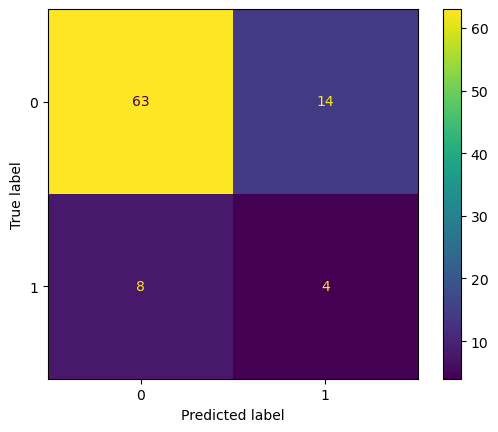

In [370]:
pred00split = r00_split.predict(X_test)
pred00split = list(map(round,pred00split))
print('\nTest accuracy : \n', accuracy_score(y_test, pred00split))
cm00split = confusion_matrix(y_test, pred00split) 
print ('\nConfusion Matrix : \n', cm00split) 
cm00split_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm00split)
cm00split_display.plot()

In [371]:
acc_ols_sp = metrics.accuracy_score(y_test, pred00split)
print('accuracy', acc_ols_sp)

pre_ols_sp = metrics.precision_score(y_test, pred00split, average = None)
print('precision', pre_ols_sp)

senrec_ols_sp = metrics.recall_score(y_test, pred00split, average = None)
print('sensitivity recall', senrec_ols_sp)

f1_ols_sp = metrics.f1_score(y_test, pred00split, average = None)
print('f1 score', f1_ols_sp)

pre_ols_sp_m = np.mean(pre_ols_sp)
senrec_ols_sp_m = np.mean(senrec_ols_sp)
f1_ols_sp_m = np.mean(f1_ols_sp)
print('mean precision', pre_ols_sp_m)
print('mean recall', senrec_ols_sp_m)
print('mean f1 score', f1_ols_sp_m)

accuracy 0.7528089887640449
precision [0.88732394 0.22222222]
sensitivity recall [0.81818182 0.33333333]
f1 score [0.85135135 0.26666667]
mean precision 0.554773082942097
mean recall 0.5757575757575758
mean f1 score 0.5590090090090091


## Logistic regression

### Without data splitting

In [360]:

# Without constant
# m00_log = sm.Logit(y, x)
# r00_log = m00_log.fit_regularized()
# r00_log.summary()

# Add constant
x_const = tools.add_constant(x)
m00_log = sm.Logit(y,x_const, max_iter = 500)
# r00_log = m00_log.fit_regularized()
r00_log = m00_log.fit()

r00_log.summary()

/home/yelhe/.local/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['max_iter']
  warnings.warn(msg, ValueWarning)


ValueError: endog must be in the unit interval.

In [342]:
# exog = m00_log.exog
# u, s, vt = np.linalg.svd(exog, 0)
# print(s)

In [343]:
print(r00_log.prsquared)
printsig(r00_log)

0.27019542639222527


,feature,0,sig
0,droad,0.005882,**
1,gvm_dwv,0.027633,*
2,bicyclecount,0.038786,*
3,z_qnr_2,0.001645,**
4,r_width_4,0.017018,*


0.8576271186440678

Test accuracy : 
 0.8576271186440678

Confusion Matrix : 
 [[239   7]
 [ 35  14]]
accuracy 0.8576271186440678
precision [0.87226277 0.66666667]
sensitivity recall [0.97154472 0.28571429]
f1 score [0.91923077 0.4       ]
mean precision 0.7694647201946472
mean recall 0.6286295005807201
mean f1 score 0.6596153846153846


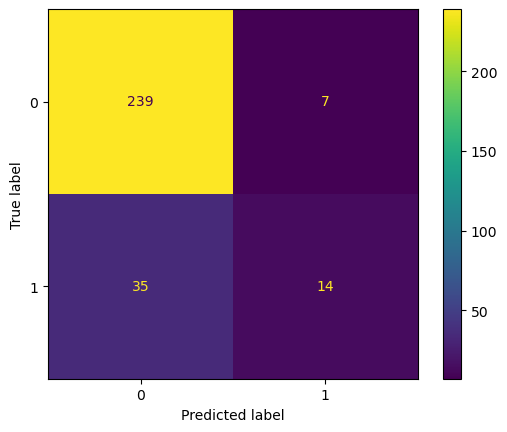

In [344]:
pred00log = r00_log.predict(x_const)
pred00log = list(map(round,pred00log))
print(accuracy_score(y, pred00log))
print('\nTest accuracy : \n', accuracy_score(y, pred00log))
cm00log = confusion_matrix(y, pred00log) 
print ('\nConfusion Matrix : \n', cm00log)
cm00log_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm00log)
cm00log_display.plot()

acc_log = metrics.accuracy_score(y, pred00log)
print('accuracy', acc_log)

pre_log = metrics.precision_score(y, pred00log, average = None)
print('precision', pre_log)

senrec_log = metrics.recall_score(y, pred00log, average = None)
print('sensitivity recall', senrec_log)

f1_log = metrics.f1_score(y, pred00log, average = None)
print('f1 score', f1_log)

pre_log_m = np.mean(pre_log)
senrec_log_m = np.mean(senrec_log)
f1_log_m = np.mean(f1_log)
print('mean precision', pre_log_m)
print('mean recall', senrec_log_m)
print('mean f1 score', f1_log_m)

### With data splitting

In [345]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
        x_const, y,
        test_size=0.15,
        random_state=12)
m00_log_split = sm.Logit(y_train1,X_train1, max_iter = 10000)
r00_log_split = m00_log_split.fit()
r00_log_split.summary()

/home/yelhe/.local/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['max_iter']
  warnings.warn(msg, ValueWarning)
/home/yelhe/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/yelhe/.local/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['max_iter']
  warnings.warn(msg, ValueWarning)


         Current function value: 0.340615
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    svp   No. Observations:                  250
Model:                          Logit   Df Residuals:                      195
Method:                           MLE   Df Model:                           54
Date:                Mon, 28 Oct 2024   Pseudo R-squ.:                  0.2679
Time:                        19:13:34   Log-Likelihood:                -85.154
converged:                      False   LL-Null:                       -116.32
Covariance Type:            nonrobust   LLR p-value:                    0.2041
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.2643    430.001     -0.008      0.994    -846.051     839.522
cmean               -0.0898      0.265     -0.339      0.735      -0.609       0.430
cmin                -2.3489   3667.624     -0.001      0.999   -7190.759    7186.061
ie                   0.2548      0.234      1.091      0.275      -0.203       0.713
mew                 -0.7083      0.332     -2.134      0.033      -1.359      -0.058
meg                  0.1615      0.347      0.465      0.642      -0.519       0.842
megmax               0.3128      0.323      0.969      0.333      -0.320       0.946
dbusl               -0.1721      0.298     -0.577      0.564      -0.756       0.412
dtraml              -0.0758      0.307     -0.247      0.805      -0.678       0.526
dtrainl             -0.2473      0.284     -0.870      0.384      -0.804       0.310
dplight             -0.2511      0.221     -1.134      0.257      -0.685       0.183
dstation             0.2914      0.279      1.045      0.296      -0.255       0.838
dparkcar            -0.0937      0.296     -0.317      0.751      -0.674       0.486
dparktw              0.0915      0.286      0.320      0.749      -0.470       0.653
dpedcro             -0.0421      0.243     -0.174      0.862      -0.518       0.433
dstopsign            0.2546      0.330      0.771      0.441      -0.392       0.902
dtrafficarea        -0.1343      0.321     -0.419      0.676      -0.763       0.495
droad                0.7407      0.346      2.141      0.032       0.063       1.419
dvfpath             -0.2397      0.305     -0.787      0.432      -0.837       0.358
gvm_dwv              0.5103      0.315      1.619      0.105      -0.107       1.128
r_width_value       -0.0771      0.314     -0.245      0.806      -0.693       0.539
speedlimit_value     0.0919      0.308      0.298      0.766      -0.512       0.696
bicyclecount        -0.4729      0.272     -1.741      0.082      -1.005       0.059
carcount            -0.3624      0.268     -1.350      0.177      -0.888       0.164
z_qnr_2              5.7162      1.840      3.107      0.002       2.110       9.322
z_qnr_3            -10.6335    368.859     -0.029      0.977    -733.583     712.316
z_qnr_4            -13.4681   1505.196     -0.009      0.993   -2963.597    2936.661
z_qnr_5             -0.4902      1.388     -0.353      0.724      -3.210       2.230
z_qnr_6              3.8967      1.692      2.303      0.021       0.581       7.213
z_qnr_8             -1.1493      1.369     -0.840      0.401      -3.832       1.534
z_qnr_9             -9.7698    248.271     -0.039      0.969    -496.373     476.833
z_qnr_10             1.6282      1.768      0.921      0.357      -1.836       5.093
z_qnr_13             0.3843      1.616      0.238      0.812      -2.784       3.552
z_qnr_14             1.5247      1.613      0.945      0.344      -1.636       4.686
z_qnr_15             1.5679      1.256      1.249      0.212      -0.893       4.029
z_qnr_17   

In [346]:
print(r00_log_split.prsquared)
printsig(r00_log_split)

0.267924822110961


,feature,0,sig
0,mew,0.032870,*
1,droad,0.032301,*
2,z_qnr_2,0.001892,**
3,z_qnr_6,0.021276,*
4,r_width_4,0.037379,*


0.9555555555555556

Test accuracy : 
 0.9555555555555556

Confusion Matrix : 
 [[40  0]
 [ 2  3]]
accuracy 0.9555555555555556
precision [0.95238095 1.        ]
sensitivity recall [1.  0.6]
f1 score [0.97560976 0.75      ]
mean precision 0.9761904761904762
mean recall 0.8
mean f1 score 0.8628048780487805


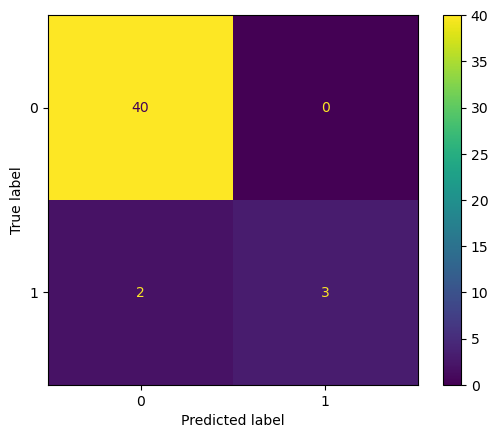

In [347]:
pred00log_split = r00_log.predict(X_test1)
pred00log_split = list(map(round,pred00log_split))
print(accuracy_score(y_test1, pred00log_split))
print('\nTest accuracy : \n', accuracy_score(y_test1, pred00log_split))
cm00log_split = confusion_matrix(y_test1, pred00log_split) 
print ('\nConfusion Matrix : \n', cm00log_split)
cm00log_split_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm00log_split)
cm00log_split_display.plot()

acc_log_split = metrics.accuracy_score(y_test1, pred00log_split)
print('accuracy', acc_log_split)

pre_log_split = metrics.precision_score(y_test1, pred00log_split, average = None)
print('precision', pre_log_split)

senrec_log_split = metrics.recall_score(y_test1, pred00log_split, average = None)
print('sensitivity recall', senrec_log_split)

f1_log_split = metrics.f1_score(y_test1, pred00log_split, average = None)
print('f1 score', f1_log_split)

pre_log_split_m = np.mean(pre_log_split)
senrec_log_split_m = np.mean(senrec_log_split)
f1_log_split_m = np.mean(f1_log_split)
print('mean precision', pre_log_split_m)
print('mean recall', senrec_log_split_m)
print('mean f1 score', f1_log_split_m)

# Step wise feature selection

In [304]:
# Check sklearn metrics name for feature selection
# sklearn.metrics.get_scorer_names()

## Ordinary Least Squares Regression model

### Sequential forward floating selection

In [51]:
# # n = best, linear regression, scoring = neg_mean_squared_error, cv = 5
sffslin0 = featureselection_lin(True, 'neg_mean_squared_error', 5, x, y) 
print(sffslin0.k_feature_names_)
print(len(sffslin0.k_feature_names_))
print(sffslin0.k_score_)



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

None


TypeError: object of type 'NoneType' has no len()

In [ ]:
# # n = best, linear regression, scoring = neg_mean_squared_error, cv = 10
sffslin1 = featureselection_lin(True, 'neg_mean_squared_error', 10, x, y) 
print(sffslin1.k_feature_names_)
print(len(sffslin1.k_feature_names_))
print(sffslin1.k_score_)


In [114]:
# # # n = best, linear regression, scoring = neg_mean_squared_error, cv = 15
# print(selected_features6.k_feature_names_)
# print(len(selected_features6.k_feature_names_))
# print(selected_features6.k_score_)
# # 34

In [115]:
# # # n = best, linear regression, scoring = neg_mean_squared_error, cv = 20
# print(selected_features7.k_feature_names_)
# print(len(selected_features7.k_feature_names_))
# print(selected_features7.k_score_)
# 37

In [117]:
# # n = best, linear regression, scoring = r2, cv = 5
sffslin2 = featureselection_lin(True, 'r2', 5, x, y) 
print(sffslin2.k_feature_names_)
print(len(sffslin2.k_feature_names_))
print(sffslin2.k_score_)

('ie', 'mew', 'cmin', 'dstopsign', 'dvfpath', 'r_width_value', 'speedlimit_value', 'z_qnr_3', 'z_qnr_10', 'z_qnr_11', 'z_qnr_13', 'z_qnr_14', 'z_qnr_23', 'z_knr_5', 'z_knr_6', 'z_knr_7', 'z_knr_9', 'r_width_1', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_1', 'speedlimit_4')
25
0.09083514182795516


In [131]:
# n = best, linear regression, scoring = r2, cv = 10
sffslin3 = featureselection_lin(True, 'r2', 10, x, y) 
print(sffslin3.k_feature_names_)
print(len(sffslin3.k_feature_names_))
print(sffslin3.k_score_)

('cp', 'ie', 'mew', 'megmax', 'dparktw', 'dpedcro', 'dstopsign', 'droad', 'r_width_value', 'speedlimit_value', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_6', 'z_qnr_9', 'z_qnr_10', 'z_qnr_12', 'z_qnr_13', 'z_qnr_14', 'z_qnr_15', 'z_qnr_16', 'z_qnr_18', 'z_qnr_23', 'z_qnr_25', 'z_qnr_27', 'z_qnr_30', 'z_qnr_31', 'z_qnr_32', 'z_knr_1', 'z_knr_2', 'z_knr_6', 'z_knr_7', 'z_knr_8', 'z_knr_11', 'r_width_1', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_1', 'speedlimit_4', 'speedlimit_5')
43
-0.003116770937851121


In [118]:
# # # n = best, linear regression, scoring = r2, cv = 15
# print(selected_features9.k_feature_names_)
# print(len(selected_features9.k_feature_names_))
# print(selected_features9.k_score_)
# # 59

In [119]:
# # # n = best, linear regression, scoring = r2, cv = 20
# print(selected_features10.k_feature_names_)
# print(len(selected_features10.k_feature_names_))
# print(selected_features10.k_score_)
# # 73

In [120]:
# # # n = best, linear regression, scoring = neg median absolute error, cv = 5
sffslin4 = featureselection_lin(True, 'neg_median_absolute_error', 5, x, y) 
print(sffslin4.k_feature_names_)
print(len(sffslin4.k_feature_names_))
print(sffslin4.k_score_)

('z_qnr_7', 'trafficarea_2', 'r_width_4', 'speedlimit_1', 'speedlimit_4')
5
-0.18490933143765312


In [133]:
# # # n = best, linear regression, scoring = neg median absolute error, cv = 10
sffslin5 = featureselection_lin(True, 'neg_median_absolute_error', 10, x, y) 
print(sffslin5.k_feature_names_)
print(len(sffslin5.k_feature_names_))
print(sffslin5.k_score_)

('r_width_value', 'speedlimit_value', 'z_qnr_20', 'z_qnr_22', 'z_qnr_26', 'trafficarea_2', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_4')
12
-0.13157577362107836


In [121]:
# # # n = best, linear regression, scoring = neg median absolute error, cv = 15
# print(selected_features12.k_feature_names_)
# print(len(selected_features12.k_feature_names_))
# print(selected_features12.k_score_)
# 21

In [122]:
# # n = best, linear regression, scoring = neg median absolute error, cv = 20
# print(selected_features13.k_feature_names_)
# print(len(selected_features13.k_feature_names_))
# print(selected_features13.k_score_)
# # 11

In [125]:
# # # n = best, linear regression, scoring = neg mean absolute error, cv = 5
sffslin6 = featureselection_lin(True, 'neg_mean_absolute_error', 5, x, y) 
print(sffslin6.k_feature_names_)
print(len(sffslin6.k_feature_names_))
print(sffslin6.k_score_)

('dtrafficarea', 'z_qnr_10', 'trafficarea_2', 'r_width_4', 'r_width_5', 'r_surface_1', 'speedlimit_1', 'speedlimit_3', 'speedlimit_4', 'speedlimit_5')
10
-0.28187575192075237


In [124]:
# # # n = best, linear regression, scoring = neg mean absolute error, cv = 10
sffslin7 = featureselection_lin(True, 'neg_mean_absolute_error', 10, x, y) 
print(sffslin7.k_feature_names_)
print(len(sffslin7.k_feature_names_))
print(sffslin7.k_score_)

('dplight', 'r_width_value', 'speedlimit_value', 'z_qnr_23', 'z_qnr_26', 'z_knr_4', 'z_knr_9', 'trafficarea_2', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_4')
14
-0.2420524177831998


In [126]:
# # n = best, linear regression, scoring = neg mean absolute error, cv = 15
# print(selected_features15.k_feature_names_)
# print(len(selected_features15.k_feature_names_))
# print(selected_features15.k_score_)
# # 24

In [127]:
# # # n = best, linear regression, scoring = neg mean absolute error, cv = 20
# print(selected_features16.k_feature_names_)
# print(len(selected_features16.k_feature_names_))
# print(selected_features16.k_score_)
# # 22

In [135]:
selected_columns_linr_sffs = []
selected_columns_linr_sffs = {'nmse_cv5':list(sffslin0.k_feature_names_), 
                              'nmse_cv10':list(sffslin1.k_feature_names_), 
                              'r2_cv5':list(sffslin2.k_feature_names_), 
                              'r2_cv10':list(sffslin3.k_feature_names_), 
                              'nmedae_cv5':list(sffslin4.k_feature_names_), 
                              'nmedae_cv10':list(sffslin5.k_feature_names_), 
                              'nmeae_cv5':list(sffslin6.k_feature_names_), 
                              'nmeae_cv10':list(sffslin7.k_feature_names_)}

In [136]:
df_sf_linr_sffs = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in selected_columns_linr_sffs.items()]))

In [137]:
df_sf_linr_sffs.to_csv('/home/yelhe/script/mtp/tables/updated_sffs_linearreg.csv', index = True)

In [152]:
# selected_columns = list(sffslin.k_feature_names_)


In [257]:
# # OLS
# df_selected = dfacrpv[selected_columns]

# m0 = sm.OLS(y, df_selected)
# r0 = m0.fit()
# r0.summary()

### Sequential backward floating selection

In [154]:
# # n = best, linear regression, backward, scoring = neg_mean_squared_error, cv = 5
sbfslin0 = featureselection_lin(False, 'neg_mean_squared_error', 5, x, y) 
print(sbfslin0.k_feature_names_)
print(len(sbfslin0.k_feature_names_))
print(sbfslin0.k_score_)

('dtrafficarea', 'droad', 'z_qnr_10', 'z_qnr_30', 'z_qnr_31', 'z_knr_8', 'trafficarea_2', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_3', 'speedlimit_4', 'speedlimit_5')
14
-0.1468143631396745


In [155]:
# # n = best, linear regression, backward, scoring = neg_mean_squared_error, cv = 10
sbfslin1 = featureselection_lin(False, 'neg_mean_squared_error', 10, x, y) 
print(sbfslin1.k_feature_names_)
print(len(sbfslin1.k_feature_names_))
print(sbfslin1.k_score_)


('ie', 'dvfpath', 'r_width_value', 'speedlimit_value', 'z_qnr_10', 'z_qnr_23', 'z_qnr_25', 'z_qnr_26', 'z_knr_4', 'z_knr_9', 'trafficarea_2', 'r_width_1', 'r_width_2', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_3', 'speedlimit_4')
20
-0.12100686105804259


In [156]:
# # n = best, linear regression, backward, scoring = neg_mean_squared_error, cv = 15
# print(sbfs2.k_feature_names_)
# print(len(sbfs2.k_feature_names_))
# print(sbfs2.k_score_)
# # 26

In [157]:
# # n = best, linear regression, backward, scoring = neg_mean_squared_error, cv = 20
# print(sbfs3.k_feature_names_)
# print(len(sbfs3.k_feature_names_))
# print(sbfs3.k_score_)
# # 52

In [158]:
# # n = best, linear regression, backward, scoring = r2, cv = 5
sbfslin2 = featureselection_lin(False, 'r2', 5, x, y) 
print(sbfslin2.k_feature_names_)
print(len(sbfslin2.k_feature_names_))
print(sbfslin2.k_score_)

('ie', 'mew', 'cmin', 'dstopsign', 'dvfpath', 'r_width_value', 'speedlimit_value', 'z_qnr_3', 'z_qnr_10', 'z_qnr_11', 'z_qnr_13', 'z_qnr_14', 'z_qnr_23', 'z_knr_5', 'z_knr_6', 'z_knr_7', 'z_knr_9', 'r_width_1', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_1', 'speedlimit_4')
25
0.09083514182795516


In [159]:
# # n = best, linear regression, backward, scoring = r2, cv = 10
sbfslin3 = featureselection_lin(False, 'r2', 10, x, y) 
print(sbfslin3.k_feature_names_)
print(len(sbfslin3.k_feature_names_))
print(sbfslin3.k_score_)

('ie', 'mew', 'cmin', 'dstopsign', 'dvfpath', 'r_width_value', 'speedlimit_value', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_6', 'z_qnr_9', 'z_qnr_10', 'z_qnr_13', 'z_qnr_14', 'z_qnr_15', 'z_qnr_16', 'z_qnr_18', 'z_qnr_25', 'z_qnr_26', 'z_qnr_30', 'z_qnr_31', 'z_qnr_32', 'z_knr_1', 'z_knr_2', 'z_knr_5', 'z_knr_6', 'z_knr_7', 'z_knr_8', 'trafficarea_1', 'trafficarea_2', 'r_width_1', 'r_width_2', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_3', 'speedlimit_4', 'speedlimit_5')
41
-0.0037091494395070645


In [162]:
# # n = best, linear regression, backward, scoring = r2, cv = 15


In [163]:
# # n = best, linear regression, backward, scoring = r2, cv = 20


In [165]:
# # n = best, linear regression, backward, scoring = neg median aboslute error, cv = 5
sbfslin4 = featureselection_lin(False, 'neg_median_absolute_error', 5, x, y) 
print(sbfslin4.k_feature_names_)
print(len(sbfslin4.k_feature_names_))
print(sbfslin4.k_score_)

('z_qnr_7', 'z_qnr_8', 'z_qnr_12', 'z_qnr_16', 'z_qnr_22', 'z_qnr_27', 'z_knr_4', 'z_knr_5', 'z_knr_9', 'trafficarea_2', 'r_width_4', 'r_width_6', 'speedlimit_4')
13
-0.1534518932857683


In [166]:
# # n = best, linear regression, backward, scoring = neg median aboslute error, cv = 10
sbfslin5 = featureselection_lin(False, 'neg_median_absolute_error', 10, x, y) 
print(sbfslin5.k_feature_names_)
print(len(sbfslin5.k_feature_names_))
print(sbfslin5.k_score_)

('r_width_value', 'speedlimit_value', 'z_qnr_20', 'z_qnr_22', 'z_qnr_26', 'trafficarea_2', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_4')
12
-0.13157577362107836


In [252]:
# # n = best, linear regression, backward, scoring = neg median aboslute error, cv = 15


('z_qnr_1', 'z_qnr_5', 'z_qnr_7', 'z_qnr_16', 'z_qnr_20', 'z_qnr_26', 'z_qnr_28', 'z_qnr_29', 'z_knr_9', 'trafficarea_3', 'r_width_4', 'speedlimit_2', 'speedlimit_4', 'speedlimit_6')
14
-0.14787659233510794


In [254]:
# # n = best, linear regression, backward, scoring = neg median aboslute error, cv = 20


('z_knr_12', 'trafficarea_1', 'trafficarea_2', 'trafficarea_3', 'r_width_4', 'r_width_6', 'speedlimit_2', 'speedlimit_4', 'speedlimit_6')
9
-0.12273976660347483


In [167]:
# # n = best, linear regression, backward, scoring = neg mean absolute error, cv = 5
sbfslin6 = featureselection_lin(False, 'neg_mean_absolute_error', 5, x, y) 
print(sbfslin6.k_feature_names_)
print(len(sbfslin6.k_feature_names_))
print(sbfslin6.k_score_)

('dtrafficarea', 'z_qnr_10', 'trafficarea_2', 'r_width_4', 'r_width_5', 'r_surface_1', 'speedlimit_1', 'speedlimit_3', 'speedlimit_4', 'speedlimit_5')
10
-0.28187575192075237


In [168]:
# # n = best, linear regression, backward, scoring = neg mean aboslute error, cv = 10
sbfslin7 = featureselection_lin(False, 'neg_mean_absolute_error', 10, x, y) 
print(sbfslin7.k_feature_names_)
print(len(sbfslin7.k_feature_names_))
print(sbfslin7.k_score_)

('dplight', 'r_width_value', 'speedlimit_value', 'z_qnr_23', 'z_qnr_26', 'z_knr_4', 'z_knr_9', 'trafficarea_2', 'r_width_3', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_4')
14
-0.2420524177831998


In [169]:
# # n = best, linear regression, backward, scoring = neg mean aboslute error, cv = 15


In [170]:
# n = best, linear regression, backward, scoring = neg mean aboslute error, cv = 20


In [171]:
selected_columns_linr_sbfs = []
selected_columns_linr_sbfs = {'all': cnu,
                              'nmse_cv5':list(sbfslin0.k_feature_names_), 
                              'nmse_cv10':list(sbfslin1.k_feature_names_), 
                              'r2_cv5':list(sbfslin2.k_feature_names_), 
                              'r2_cv10':list(sbfslin3.k_feature_names_), 
                              'nmedae_cv5':list(sbfslin4.k_feature_names_), 
                              'nmedae_cv10':list(sbfslin5.k_feature_names_),
                              'nmeae_cv5':list(sbfslin6.k_feature_names_), 
                              'nmeae_cv10':list(sbfslin7.k_feature_names_)}

In [172]:
df_sf_linr_sbfs = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in selected_columns_linr_sbfs.items()]))

In [173]:
df_sf_linr_sbfs.to_csv('/home/yelhe/script/mtp/tables/updated_sbfs_linearreg.csv', index = True)

In [188]:
sbfs_columns = list(sbfslin7.k_feature_names_)

In [100]:
# df_output = pd.read_csv('/home/yelhe/script/mtp/tables/updated_sbfs_linearreg.csv')

In [101]:
# df_output.columns

Index(['Unnamed: 0', 'all', 'nmse_cv5', 'nmse_cv10', 'r2_cv5', 'r2_cv10',
       'nmedae_cv5', 'nmedae_cv10', 'nmeae_cv5', 'nmeae_cv10'],
      dtype='object')

In [102]:
# prsq_lin_sffs = []
# prsq_lin_sbfs = []

In [131]:


# ## For sffs
# l = list(df_output['nmeae_cv10'].dropna())

# # x_selected
# xs = dfacrpv[l]

In [132]:
# # OLS
# xs_const = tools.add_constant(xs) 
# # X_train, X_test, y_train, y_test = train_test_split(
# #         df_selected, y,
# #         test_size=0.3,
# #         random_state=0)

# m1 = sm.OLS(y, xs_const)
# r1 = m1.fit()
# r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    acp   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     79.61
Date:                Fri, 04 Oct 2024   Prob (F-statistic):          7.28e-155
Time:                        18:37:30   Log-Likelihood:                -274.08
No. Observations:                1087   AIC:                             578.2
Df Residuals:                    1072   BIC:                             653.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3365      0.070     -4.815      0.000      -0.474      -0.199
dplight              0.0138      0.010      1.390      0.165      -0.006       0.033
r_width_value       -0.0917      0.019     -4.732      0.000      -0.130      -0.054
speedlimit_value    -0.0821      0.011     -7.253      0.000      -0.104      -0.060
z_qnr_23            -0.2385      0.070     -3.388      0.001      -0.377      -0.100
z_qnr_26            -0.2785      0.098     -2.841      0.005      -0.471      -0.086
z_knr_4              0.2378      0.034      6.982      0.000       0.171       0.305
z_knr_9              0.2139      0.033      6.388      0.000       0.148       0.280
trafficarea_2       -0.2257      0.038     -5.913      0.000      -0.301      -0.151
r_width_3            0.1765      0.047      3.741      0.000       0.084       0.269
r_width_4            0.1781      0.035      5.041      0.000       0.109       0.247
r_width_5            0.2076      0.037      5.652      0.000       0.136       0.280
r_width_6            0.1797      0.043      4.192      0.000       0.096       0.264
r_surface_1          0.3681      0.065      5.667      0.000       0.241       0.495
speedlimit_4         0.7182      0.028     25.208      0.000       0.662       0.774
==============================================================================
Omnibus:                      162.499   Durbin-Watson:                   0.834
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              293.176
Skew:                           0.926   Prob(JB):                     2.18e-64
Kurtosis:                       4.744   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
# prsq_lin_sbfs.append(r1.rsquared_adj)

In [134]:
prsq_lin_sbfs

[0.46863270188062633,
 0.5228831125625122,
 0.5083388939077372,
 0.539473692009008,
 0.4665037273438992,
 0.47415516300643146,
 0.46239446930329153,
 0.5033154652889078]

In [96]:
prsq_lin_sffs

[0.46863270188062633,
 0.5170176533771211,
 0.5083388939077372,
 0.5299324651839028,
 0.42039652784715786,
 0.47415516300643146,
 0.46239446930329153,
 0.5033154652889078]

## Logistic Regression model

### Sequential forward floating selection

In [185]:
# # n = best, logistic regression, scoring = accuracy, cv = 5
sffslog0 = featureselection_log(True, 'accuracy', 5, x, y)
print(sffslog0.k_feature_names_)
print(len(sffslog0.k_feature_names_))
print(sffslog0.k_score_)


('cmean', 'cmin', 'mew', 'meg', 'megmax', 'dbusl', 'dtraml', 'dtrainl', 'dplight', 'dstation', 'dparktw', 'dpedcro', 'dstopsign', 'dtrafficarea', 'droad', 'dvfpath', 'gvm_dwv', 'r_width_value', 'speedlimit_value', 'bicyclecount', 'carcount', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_5', 'z_qnr_6', 'z_qnr_8', 'z_qnr_9', 'z_qnr_10', 'z_qnr_13', 'z_qnr_14', 'z_qnr_15', 'z_qnr_17', 'z_qnr_18', 'z_qnr_19', 'z_qnr_20', 'z_qnr_22', 'z_qnr_24', 'z_qnr_25', 'z_qnr_28', 'z_knr_1', 'z_knr_3', 'z_knr_7', 'z_knr_8', 'z_knr_11', 'trafficarea_1', 'r_width_2', 'r_width_3', 'r_width_4', 'r_width_6', 'speedlimit_1')
51
0.8745762711864407


In [53]:
# n = best, logistic regression, scoring = accuracy, cv = 10
sffslog1 = featureselection_log(True, 'accuracy', 10, x, y)
print(sffslog1.k_feature_names_)
print(len(sffslog1.k_feature_names_))
print(sffslog1.k_score_)


('cmean', 'cmin', 'ie', 'mew', 'meg', 'megmax', 'dbusl', 'dtraml', 'dtrainl', 'dplight', 'dstation', 'dpedcro', 'dstopsign', 'dtrafficarea', 'droad', 'dvfpath', 'gvm_dwv', 'bicyclecount', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_5', 'z_qnr_6', 'z_qnr_7', 'z_qnr_9', 'z_qnr_10', 'z_qnr_11', 'z_qnr_12', 'z_qnr_13', 'z_qnr_14', 'z_qnr_15', 'z_qnr_16', 'z_qnr_23', 'z_qnr_24', 'z_qnr_25', 'z_qnr_26', 'z_qnr_27', 'z_qnr_28', 'z_qnr_29', 'z_qnr_30', 'z_qnr_31', 'z_qnr_32', 'z_knr_2', 'z_knr_3', 'trafficarea_2', 'r_width_1', 'r_width_2', 'r_width_5', 'speedlimit_1', 'speedlimit_4', 'speedlimit_5')
51
0.8656048250084947


In [54]:
# # # n = best, logistic regression, scoring = accuracy, cv = 15
# sffslog2 = featureselection_log(True, 'accuracy', 15, x, y)
# print(sffslog2.k_feature_names_)
# print(len(sffslog2.k_feature_names_))
# print(sffslog2.k_score_)

In [55]:
# # # n = best, logistic regression, scoring = accuracy, cv = 20
# sffslog3 = featureselection_log(True, 'accuracy', 20, x, y)
# print(sffslog3.k_feature_names_)
# print(len(sffslog3.k_feature_names_))
# print(sffslog3.k_score_)
# #

In [56]:
# # n = best, logistic regression, scoring = f1, cv = 5
sffslog2 = featureselection_log(True, 'f1', 5, x, y)
print(sffslog2.k_feature_names_)
print(len(sffslog2.k_feature_names_))
print(sffslog2.k_score_)


('cmean', 'cmin', 'ie', 'mew', 'meg', 'megmax', 'dbusl', 'dtraml', 'dplight', 'dstation', 'dparkcar', 'dparktw', 'dpedcro', 'dtrafficarea', 'droad', 'dvfpath', 'gvm_dwv', 'r_width_value', 'z_qnr_1', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_5', 'z_qnr_6', 'z_qnr_7', 'z_qnr_10', 'z_qnr_11', 'z_qnr_14', 'z_qnr_16', 'z_qnr_17', 'z_qnr_20', 'z_qnr_22', 'z_qnr_23', 'z_qnr_28', 'z_qnr_29', 'z_qnr_30', 'z_qnr_31', 'z_qnr_32', 'z_knr_4', 'z_knr_5', 'z_knr_10', 'trafficarea_2', 'r_width_1', 'r_width_2', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_1', 'speedlimit_4', 'speedlimit_5')
50
0.7078221869009644


In [57]:
# # n = best, logistic regression, scoring = f1, cv = 10
sffslog3 = featureselection_log(True, 'f1', 10, x, y)
print(sffslog3.k_feature_names_)
print(len(sffslog3.k_feature_names_))
print(sffslog3.k_score_)


('cmean', 'cmin', 'ie', 'mew', 'meg', 'megmax', 'dtraml', 'dplight', 'dstation', 'dparkcar', 'dparktw', 'dpedcro', 'dstopsign', 'dtrafficarea', 'droad', 'dvfpath', 'gvm_dwv', 'carcount', 'r_width_value', 'speedlimit_value', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_5', 'z_qnr_6', 'z_qnr_7', 'z_qnr_8', 'z_qnr_10', 'z_qnr_11', 'z_qnr_12', 'z_qnr_15', 'z_qnr_16', 'z_qnr_19', 'z_qnr_20', 'z_qnr_22', 'z_qnr_23', 'z_qnr_29', 'z_qnr_30', 'z_qnr_31', 'z_knr_3', 'z_knr_4', 'z_knr_5', 'z_knr_10', 'trafficarea_2', 'r_width_2', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_4', 'speedlimit_5')
51
0.7104828365703021


In [58]:
# # # n = best, logistic regression, scoring = f1, cv = 15
# sffslog6 = featureselection_log(True, 'f1', 15, x, y)
# print(sffslog6.k_feature_names_)
# print(len(sffslog6.k_feature_names_))
# print(sffslog6.k_score_)
# #

In [59]:
# # # n = best, logistic regression, scoring = f1, cv = 20
# sffslog7 = featureselection_log(True, 'f1', 20, x, y)
# print(sffslog7.k_feature_names_)
# print(len(sffslog7.k_feature_names_))
# print(sffslog7.k_score_)
# #

In [299]:
# n = best, logistic regression, scoring = precision, cv = 5
# sffslog4 = featureselection_log(True, 'precision', 5, x, y)
# print(sffslog4.k_feature_names_)
# print(len(sffslog4.k_feature_names_))
# print(sffslog4.k_score_)
# ('cmean', 'cmin', 'ie', 'mew', 'meg', 'megmax', 'dbusl', 'dtraml', 'dtrainl', 'dplight', 'dstation', 'dparkcar', 'dpedcro', 'dstopsign', 'dvfpath', 'bicyclecount', 'carcount', 'z_qnr_1', 'z_qnr_2', 'z_qnr_4', 'z_qnr_6', 'z_qnr_13', 'z_qnr_14', 'z_qnr_22', 'z_knr_10', 'trafficarea_2', 'speedlimit_4')
# 27
# 0.8925816112608566

In [298]:
# # # # n = best, logistic regression, scoring = precision, cv = 10
# sffslog5 = featureselection_log(True, 'precision', 10, x, y)
# print(sffslog5.k_feature_names_)
# print(len(sffslog5.k_feature_names_))
# print(sffslog5.k_score_)
# ('cmean', 'cmin', 'ie', 'mew', 'meg', 'megmax', 'dbusl', 'dtraml', 'dtrainl', 'dplight', 'dstation', 'dparktw', 'dpedcro', 'dstopsign', 'dtrafficarea', 'droad', 'gvm_dwv', 'bicyclecount', 'carcount', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_6', 'z_qnr_9', 'z_qnr_10', 'z_qnr_12', 'z_qnr_13', 'z_qnr_15', 'z_qnr_16', 'z_qnr_23', 'z_qnr_24', 'z_qnr_25', 'z_qnr_26', 'z_qnr_27', 'z_qnr_28', 'z_qnr_29', 'z_qnr_30', 'z_qnr_31', 'z_qnr_32', 'z_knr_2', 'trafficarea_2', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_1', 'speedlimit_4', 'speedlimit_5')
# 47
# 0.8915503341687552

In [62]:
# # # n = best, logistic regression, scoring = precision, cv = 15
# sffslog10 = featureselection_log(True, 'precision', 15, x, y)
# print(sffslog10.k_feature_names_)
# print(len(sffslog10.k_feature_names_))
# print(sffslog10.k_score_)

In [63]:
# # # n = best, logistic regression, scoring = precision, cv = 20
# sffslog11 = featureselection_log(True, 'precision', 20, x, y)
# print(sffslog11.k_feature_names_)
# print(len(sffslog11.k_feature_names_))
# print(sffslog11.k_score_)


In [64]:
# # n = best, logistic regression, scoring = recall, cv = 5
sffslog6 = featureselection_log(True, 'recall', 5, x, y)
print(sffslog6.k_feature_names_)
print(len(sffslog6.k_feature_names_))
print(sffslog6.k_score_)


('cmean', 'cmin', 'ie', 'mew', 'meg', 'megmax', 'dbusl', 'dtraml', 'dplight', 'dstation', 'dparkcar', 'dparktw', 'dpedcro', 'dstopsign', 'dtrafficarea', 'droad', 'dvfpath', 'gvm_dwv', 'carcount', 'r_width_value', 'speedlimit_value', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_5', 'z_qnr_6', 'z_qnr_8', 'z_qnr_9', 'z_qnr_10', 'z_qnr_11', 'z_qnr_12', 'z_qnr_14', 'z_qnr_15', 'z_qnr_16', 'z_qnr_17', 'z_qnr_21', 'z_qnr_22', 'z_qnr_24', 'z_qnr_26', 'z_qnr_27', 'z_qnr_29', 'z_qnr_30', 'z_qnr_31', 'z_qnr_32', 'z_knr_4', 'z_knr_5', 'z_knr_8', 'trafficarea_2', 'r_width_2', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_1', 'speedlimit_4', 'speedlimit_5')
56
0.6474576271186441


In [65]:
# # n = best, logistic regression, scoring = recall, cv = 10
sffslog7 = featureselection_log(True, 'recall', 10, x, y)
print(sffslog7.k_feature_names_)
print(len(sffslog7.k_feature_names_))
print(sffslog7.k_score_)


('cmean', 'cmin', 'ie', 'mew', 'meg', 'megmax', 'dtraml', 'dtrainl', 'dplight', 'dparkcar', 'dpedcro', 'dtrafficarea', 'droad', 'dvfpath', 'bicyclecount', 'carcount', 'speedlimit_value', 'z_qnr_2', 'z_qnr_3', 'z_qnr_4', 'z_qnr_6', 'z_qnr_7', 'z_qnr_9', 'z_qnr_10', 'z_qnr_15', 'z_qnr_16', 'z_qnr_19', 'z_qnr_23', 'z_qnr_24', 'z_qnr_27', 'z_qnr_29', 'z_qnr_30', 'z_qnr_31', 'z_qnr_32', 'z_knr_2', 'z_knr_4', 'z_knr_5', 'r_width_2', 'r_width_4', 'r_width_5', 'r_surface_1', 'speedlimit_4')
42
0.657471264367816


In [66]:
# # # n = best, logistic regression, scoring = recall, cv = 15
# sffslog14 = featureselection_log(True, 'recall', 15, x, y)
# print(sffslog14.k_feature_names_)
# print(len(sffslog14.k_feature_names_))
# print(sffslog14.k_score_)
# #

In [67]:
# # # n = best, logistic regression, scoring = recall, cv = 20
# sffslog15 = featureselection_log(True, 'recall', 20, x, y)
# print(sffslog15.k_feature_names_)
# print(len(sffslog15.k_feature_names_))
# print(sffslog15.k_score_)
# #

In [68]:
# For part 
selected_columns_logr_sffs = []
selected_columns_logr_sffs = {'all': cnvif,
                              'acc_cv5':list(sffslog0.k_feature_names_), 
                              'acc_cv10':list(sffslog1.k_feature_names_), 
                              'f1_cv5':list(sffslog2.k_feature_names_), 
                              'f1_cv10':list(sffslog3.k_feature_names_), 
                              'pre_cv5':list(sffslog4.k_feature_names_), 
                              'pre_cv10':list(sffslog5.k_feature_names_),
                              'rec_cv5':list(sffslog6.k_feature_names_), 
                              'rec_cv10':list(sffslog7.k_feature_names_)
                              }
df_sf_logr_sffs = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in selected_columns_logr_sffs.items()]))
df_sf_logr_sffs.to_csv('/home/yelhe/script/mtp/tables/vif_sffs_logisticreg.csv', index = True)

### Sequential backward floating selection

In [69]:
# n = best, logistic regression, scoring = accuracy, cv = 5
sbfslog0 = featureselection_log(False, 'accuracy', 5, x, y)
print(sbfslog0.k_feature_names_)
print(len(sbfslog0.k_feature_names_))
print(sbfslog0.k_score_)


('cmean', 'ie', 'meg', 'dvfpath', 'r_width_value', 'z_qnr_5', 'z_qnr_7', 'z_qnr_11', 'z_qnr_22', 'z_knr_4', 'z_knr_10', 'trafficarea_2', 'r_width_1', 'r_width_2', 'r_width_4', 'speedlimit_1', 'speedlimit_4')
17
0.8711960427852704


In [70]:
# n = best, logistic regression, scoring = accuracy, cv = 10
sbfslog1 = featureselection_log(False, 'accuracy', 10, x, y)
print(sbfslog1.k_feature_names_)
print(len(sbfslog1.k_feature_names_))
print(sbfslog1.k_score_)


('cmean', 'ie', 'dtraml', 'dparkcar', 'dpedcro', 'dstopsign', 'dtrafficarea', 'dvfpath', 'speedlimit_value', 'z_qnr_7', 'z_qnr_8', 'z_qnr_10', 'z_qnr_26', 'z_qnr_32', 'z_knr_4', 'z_knr_5', 'z_knr_10', 'trafficarea_2', 'r_width_2', 'r_width_4', 'r_width_5', 'r_width_6', 'speedlimit_1', 'speedlimit_4')
24
0.8756795786612301


In [71]:
# # n = best, logistic regression, scoring = accuracy, cv = 15
# sbfslog2 = featureselection_log(False, 'accuracy', 15, x, y)
# print(sbfslog2.k_feature_names_)
# print(len(sbfslog2.k_feature_names_))
# print(sbfslog2.k_score_)


In [72]:
# # n = best, logistic regression, scoring = accuracy, cv = 20
# sbfslog3 = featureselection_log(False, 'accuracy', 20, x, y)
# print(sbfslog3.k_feature_names_)
# print(len(sbfslog3.k_feature_names_))
# print(sbfslog3.k_score_)


In [73]:
# n = best, logistic regression, scoring = f1, cv = 5
sbfslog2 = featureselection_log(False, 'f1', 5, x, y)
print(sbfslog2.k_feature_names_)
print(len(sbfslog2.k_feature_names_))
print(sbfslog2.k_score_)

('r_width_value', 'speedlimit_value', 'z_qnr_5', 'z_qnr_6', 'z_qnr_7', 'z_qnr_8', 'z_qnr_10', 'z_qnr_11', 'z_qnr_22', 'z_qnr_26', 'z_qnr_29', 'z_knr_4', 'z_knr_5', 'z_knr_10', 'trafficarea_2', 'r_width_1', 'r_width_4', 'r_width_5', 'r_width_6', 'speedlimit_1', 'speedlimit_4')
21
0.7289902543115845


In [74]:
# n = best, logistic regression, scoring = f1, cv = 10
sbfslog3 = featureselection_log(False, 'f1', 10, x, y)
print(sbfslog3.k_feature_names_)
print(len(sbfslog3.k_feature_names_))
print(sbfslog3.k_score_)

('ie', 'dtraml', 'dtrainl', 'dpedcro', 'dvfpath', 'carcount', 'speedlimit_value', 'z_qnr_3', 'z_qnr_7', 'z_qnr_10', 'z_qnr_26', 'z_knr_3', 'z_knr_4', 'z_knr_5', 'trafficarea_2', 'r_width_1', 'r_width_2', 'r_width_5', 'speedlimit_1', 'speedlimit_4')
20
0.735872081598812


In [75]:
# # n = best, logistic regression, scoring = f1, cv = 15
# sbfslog6 = featureselection_log(False, 'f1', 15, x, y)
# print(sbfslog6.k_feature_names_)
# print(len(sbfslog6.k_feature_names_))
# print(sbfslog6.k_score_)

In [76]:
# n = best, logistic regression, scoring = f1, cv = 20
# sbfslog7 = featureselection_log(False, 'f1', 20, x, y)
# print(sbfslog7.k_feature_names_)
# print(len(sbfslog7.k_feature_names_))
# print(sbfslog7.k_score_)

In [296]:
# # n = best, logistic regression, scoring = precision, cv = 5
# sbfslog4 = featureselection_log(False, 'precision', 5, x, y)
# print(sbfslog4.k_feature_names_)
# print(len(sbfslog4.k_feature_names_))
# print(sbfslog4.k_score_)
# ('dpedcro', 'dvfpath', 'r_width_value', 'z_qnr_22', 'z_knr_10', 'trafficarea_2', 'r_width_2', 'r_width_4', 'r_width_5', 'speedlimit_4')
# 10
# 0.9094070080862535

In [297]:
# # n = best, logistic regression, scoring = precision, cv = 10
# sbfslog5 = featureselection_log(False, 'precision', 10, x, y)
# print(sbfslog5.k_feature_names_)
# print(len(sbfslog5.k_feature_names_))
# print(sbfslog5.k_score_)
# ('ie', 'dtraml', 'dpedcro', 'dvfpath', 'r_width_value', 'z_qnr_5', 'z_qnr_7', 'z_qnr_10', 'z_qnr_25', 'z_qnr_26', 'z_qnr_28', 'z_qnr_29', 'z_knr_4', 'trafficarea_2', 'r_width_1', 'r_width_2', 'r_width_4', 'r_width_5', 'speedlimit_4')
# 19
# 0.9160866910866912

In [79]:
# # n = best, logistic regression, scoring = precision, cv = 15
# sbfslog10 = featureselection_log(False, 'precision', 15, x, y)
# print(sbfslog10.k_feature_names_)
# print(len(sbfslog10.k_feature_names_))
# print(sbfslog10.k_score_)

In [80]:
# # n = best, logistic regression, scoring = precision, cv = 20
# sbfslog11 = featureselection_log(False, 'precision', 20, x, y)
# print(sbfslog11.k_feature_names_)
# print(len(sbfslog11.k_feature_names_))
# print(sbfslog11.k_score_)

In [83]:
# n = best, logistic regression, scoring = recall, cv = 5
sbfslog6 = featureselection_log(False, 'recall', 5, x, y)
print(sbfslog6.k_feature_names_)
print(len(sbfslog6.k_feature_names_))
print(sbfslog6.k_score_)

('dbusl', 'dpedcro', 'dtrafficarea', 'droad', 'r_width_value', 'speedlimit_value', 'z_qnr_5', 'z_qnr_7', 'z_qnr_8', 'z_qnr_10', 'z_qnr_11', 'z_qnr_26', 'z_qnr_31', 'z_knr_4', 'z_knr_5', 'trafficarea_2', 'r_width_4', 'r_width_5', 'r_width_6', 'r_surface_1', 'speedlimit_1', 'speedlimit_4')
22
0.6542372881355932


In [84]:
# n = best, logistic regression, scoring = recall, cv = 10
sbfslog7 = featureselection_log(False, 'recall', 10, x, y)
print(sbfslog7.k_feature_names_)
print(len(sbfslog7.k_feature_names_))
print(sbfslog7.k_score_)

('cmean', 'ie', 'dbusl', 'dtraml', 'dtrainl', 'dparkcar', 'dpedcro', 'dvfpath', 'gvm_dwv', 'carcount', 'r_width_value', 'speedlimit_value', 'z_qnr_3', 'z_qnr_7', 'z_qnr_10', 'z_qnr_16', 'z_qnr_19', 'z_qnr_25', 'z_knr_4', 'z_knr_5', 'z_knr_8', 'z_knr_10', 'trafficarea_2', 'r_width_1', 'r_width_2', 'r_width_5', 'speedlimit_1', 'speedlimit_4')
28
0.6639080459770115


In [85]:
# # n = best, logistic regression, scoring = recall, cv = 15
# sbfslog14 = featureselection_log(False, 'recall', 15, x, y)
# print(sbfslog14.k_feature_names_)
# print(len(sbfslog14.k_feature_names_))
# print(sbfslog14.k_score_)
# #

In [86]:
# # n = best, logistic regression, scoring = recall, cv = 20
# sbfslog15 = featureselection_log(False, 'recall', 20, x, y)
# print(sbfslog15.k_feature_names_)
# print(len(sbfslog15.k_feature_names_))
# print(sbfslog15.k_score_)
# #

In [87]:
# For all 
selected_columns_logr_sbfs = []
selected_columns_logr_sbfs = {'all': cnvif,
                              'acc_cv5':list(sbfslog0.k_feature_names_), 
                              'acc_cv10':list(sbfslog1.k_feature_names_),
                              'f1_cv5':list(sbfslog2.k_feature_names_), 
                              'f1_cv10':list(sbfslog3.k_feature_names_),
                              'pre_cv5':list(sbfslog4.k_feature_names_), 
                              'pre_cv10':list(sbfslog5.k_feature_names_),
                              'rec_cv5':list(sbfslog6.k_feature_names_), 
                              'rec_cv10':list(sbfslog7.k_feature_names_)
                              }
df_sf_logr_sbfs = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in selected_columns_logr_sbfs.items()]))
df_sf_logr_sbfs.to_csv('/home/yelhe/script/mtp/tables/vif_sbfs_logisticreg.csv', index = True)

In [165]:
# df_output = pd.read_csv('/home/yelhe/script/mtp/tables/vif_sbfs_logisticreg.csv')

In [166]:
df_output.columns

Index(['Unnamed: 0', 'all', 'acc_cv5', 'acc_cv10', 'f1_cv5', 'f1_cv10',
       'pre_cv5', 'pre_cv10', 'rec_cv5', 'rec_cv10'],
      dtype='object')

In [103]:
log_sffs = []
log_sbfs = []

In [281]:
# l = list(df_output['rec_cv10'].dropna())
# i = 2
i = i-1
l = list(df_output.iloc[:,i].dropna())
# l = list(sffslog0.k_feature_names_)
print(i, len(l))

8 22


In [191]:
l = list(sffslog0.k_feature_names_)

In [192]:
# x_selected
xs = dfacrsv[l]

In [194]:
# with splitting
xs_const = tools.add_constant(xs)
X_train, X_test, y_train, y_test = train_test_split(
        xs_const, y,
        test_size=0.2,
        random_state=0)
m_log_split = sm.Logit(y_train, X_train, max_iter = 400)
r_log_split = m_log_split.fit()
r_log_split.summary()

/home/yelhe/.local/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['max_iter']
  warnings.warn(msg, ValueWarning)


         Current function value: 0.191819
         Iterations: 35


LinAlgError: Singular matrix

In [303]:
# print(r_log_split.prsquared)
# printsig(r_log_split)

In [285]:
log_sbfs.append(r_log_split.prsquared)

In [302]:
# log_sbfs

In [301]:
# dfc = printsig(r_log_split)
# # dfa = pd.merge(df, dfc, on = 'feature', how = 'left')
# dfa = pd.merge(dfa, dfc, on = 'feature', how = 'left')

In [280]:
# dfa.to_csv('/home/yelhe/script/mtp/tables/sigfeatures_try.csv', index = True)

In [300]:
# df = pd.DataFrame()
# cnvifnew = cnvif.copy()
# cnvifnew.insert(0, 'const')
# print(cnvifnew)
# df['feature'] = cnvifnew